<a href="https://colab.research.google.com/github/giedriusblazys/SDA_DS_class/blob/main/SDA_Transfer_learning_example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Prepare data

In [49]:
from pathlib import Path

In [50]:
from google.colab import drive
drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [51]:
from google.colab.patches import cv2_imshow # cv2_imshow performs convertion BGR2RGB itself

In [52]:
def plot_classification(y_true, y_pred):
    target_names = searches
    labels_names = [0, 1] 
    print(classification_report(y_true, y_pred,labels=labels_names, target_names=target_names))    
    cm = confusion_matrix(y_true, y_pred,labels=labels_names)  #, normalize='true'
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
    disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
    plt.show()


def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    plt.figure(figsize=(8, 8))
    plt.subplot(2, 1, 1)
    plt.plot(acc, label='Training Accuracy')
    plt.plot(val_acc, label='Validation Accuracy')
    plt.ylim([0.5, 1])
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(2, 1, 2)
    plt.plot(loss, label='Training Loss')
    plt.plot(val_loss, label='Validation Loss')
    plt.ylim([0, 1.0])
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.xlabel('epoch')
    plt.show()

In [53]:
# searches = 'red tomato', 'green tomato'
# path = Path('/content/gdrive/My Drive/data/ripe_or_not')

searches = 'happy person', 'sad person'
data_dir = Path('/content/gdrive/My Drive/data/mood')

# for o in searches:
#     dest = (path/o)
#     dest.mkdir(exist_ok=True, parents=True)
#     download_images(dest, urls=search_images(f'{o} photo'))
#     resize_images(path/o, max_size=400, dest=path/o)

## Transfer learning with Tensorflow

In [54]:
import tensorflow as tf
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [55]:
from tensorflow.keras.callbacks import EarlyStopping

In [56]:
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
import PIL.Image

In [57]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

393


In [58]:
IMG_SIZE = (120, 120)

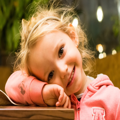

In [59]:
happy = list(data_dir.glob('happy person/*'))
im = PIL.Image.open(str(happy[1]))
im.resize(IMG_SIZE)

In [60]:
BATCH_SIZE = 32

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="training",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.25,
    subset="validation",
    seed=123,
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE)

test_dataset = val_ds.take(2)
val_ds = val_ds.skip(2)

print('Batches for testing -->', test_dataset.cardinality())
print('Batches for validating -->', val_ds.cardinality())

Found 560 files belonging to 2 classes.
Using 420 files for training.
Found 560 files belonging to 2 classes.
Using 140 files for validation.
Batches for testing --> tf.Tensor(2, shape=(), dtype=int64)
Batches for validating --> tf.Tensor(3, shape=(), dtype=int64)


In [61]:
class_names = train_ds.class_names
print(class_names)

['happy person', 'sad person']


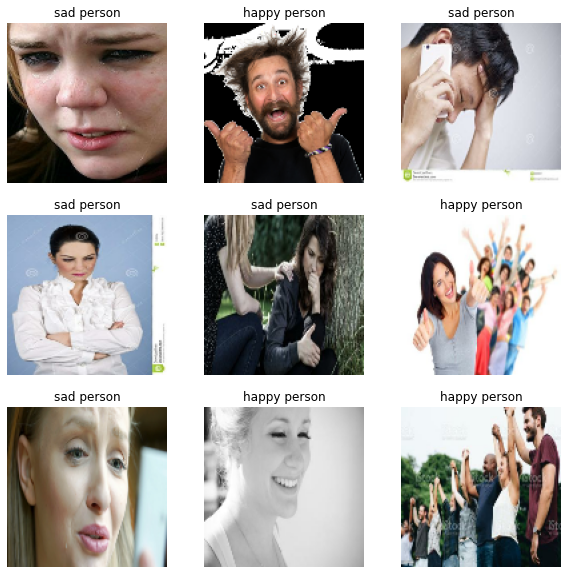

In [62]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [63]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

### Configure the dataset for performance

In [64]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.cache().prefetch(buffer_size=AUTOTUNE)

In [65]:
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.1),
])

### Create the base model from the pre-trained convnets

In [66]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)

early_stopping_monitor = EarlyStopping(patience=7, restore_best_weights=True)

total_epochs = 100

In [67]:
def create_model():
    base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

    base_model.trainable = True

    # Let's take a look to see how many layers are in the base model
    print("Number of layers in the base model: ", len(base_model.layers))

    # Fine-tune from this layer onwards
    fine_tune_at = 140

    # Freeze all the layers before the `fine_tune_at` layer
    for layer in base_model.layers[:fine_tune_at]:
        layer.trainable = False
    
    # # Add a classification head
    # image_batch, label_batch = next(iter(train_ds))
    # feature_batch = base_model(image_batch)

    global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
    # feature_batch_average = global_average_layer(feature_batch)

    prediction_layer = tf.keras.layers.Dense(1)
    # prediction_batch = prediction_layer(feature_batch_average)
    # print(prediction_batch.shape)

    inputs = tf.keras.Input(shape=IMG_SHAPE)
    x = data_augmentation(inputs)
    x = normalization_layer(x)
    x = base_model(x, training=False)
    x = global_average_layer(x)
    x = tf.keras.layers.Dropout(0.25)(x)
    outputs = prediction_layer(x)
    model = tf.keras.Model(inputs, outputs)

    base_learning_rate = 0.0001

    model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
                optimizer = tf.keras.optimizers.RMSprop(learning_rate=base_learning_rate/25),
                metrics=['accuracy'])

    return model

In [68]:
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                                include_top=False,
                                                weights='imagenet')

base_model.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_7 (InputLayer)           [(None, 120, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 60, 60, 32)   864         ['input_7[0][0]']                
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 60, 60, 32)   128         ['Conv1[0][0]']                  
                                                                                                  
 Conv1_relu (ReLU)              (None, 60, 60, 32)   0           ['bn_Conv1[0][

In [69]:
model = create_model()

model.summary()

Number of layers in the base model:  154
Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_9 (InputLayer)        [(None, 120, 120, 3)]     0         
                                                                 
 sequential_2 (Sequential)   (None, 120, 120, 3)       0         
                                                                 
 rescaling_2 (Rescaling)     (None, 120, 120, 3)       0         
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d_2   (None, 1280)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dropout_2 (Dropou

In [70]:
history = model.fit(train_ds, epochs=total_epochs, verbose=True, 
                    validation_data=val_ds, callbacks = [early_stopping_monitor])

Epoch 1/100
14/14 [==============================] - 6s 170ms/step - loss: 0.8931 - accuracy: 0.5238 - val_loss: 0.7727 - val_accuracy: 0.5658
Epoch 2/100
14/14 [==============================] - 0s 30ms/step - loss: 0.7591 - accuracy: 0.5810 - val_loss: 0.6845 - val_accuracy: 0.6053
Epoch 3/100
14/14 [==============================] - 0s 30ms/step - loss: 0.6818 - accuracy: 0.6190 - val_loss: 0.6250 - val_accuracy: 0.6184
Epoch 4/100
14/14 [==============================] - 0s 30ms/step - loss: 0.6053 - accuracy: 0.6833 - val_loss: 0.5650 - val_accuracy: 0.6579
Epoch 5/100
14/14 [==============================] - 0s 30ms/step - loss: 0.5528 - accuracy: 0.7214 - val_loss: 0.5154 - val_accuracy: 0.7237
Epoch 6/100
14/14 [==============================] - 0s 30ms/step - loss: 0.5284 - accuracy: 0.7333 - val_loss: 0.4845 - val_accuracy: 0.7368
Epoch 7/100
14/14 [==============================] - 0s 30ms/step - loss: 0.5010 - accuracy: 0.7429 - val_loss: 0.4599 - val_accuracy: 0.7368
Epoch

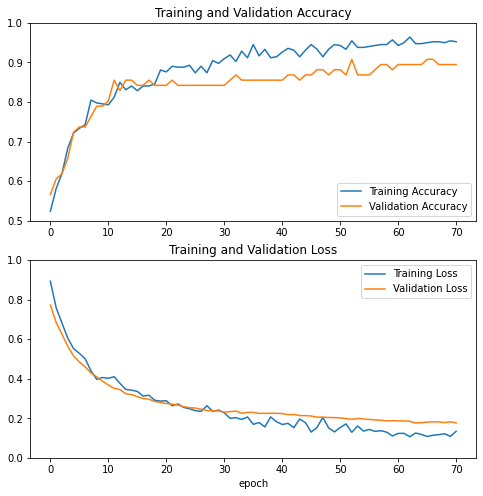

In [71]:
plot_history(history)

In [72]:
# Save the weights using the `checkpoint_path` format
latest = 'model.ckpt'
model.save_weights(latest)

In [73]:
# should prepare an actual test set with images instead
test_ds = test_dataset

In [74]:
# Create a new model instance
model = create_model()

# Load the previously saved weights
model.load_weights(latest)

# Evaluation and prediction
loss, acc = model.evaluate(test_ds, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

Number of layers in the base model:  154
2/2 - 1s - loss: 0.1500 - accuracy: 0.9375 - 1s/epoch - 708ms/step
Restored model, accuracy: 93.75%


Predictions:
 [1 0 0 0 0 0 1 1 0 1 0 0 1 1 1 1 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1]
Labels:
 [1 0 0 0 0 0 1 1 0 1 0 0 1 1 0 0 1 0 1 1 0 1 1 0 1 1 0 0 1 1 1 1]


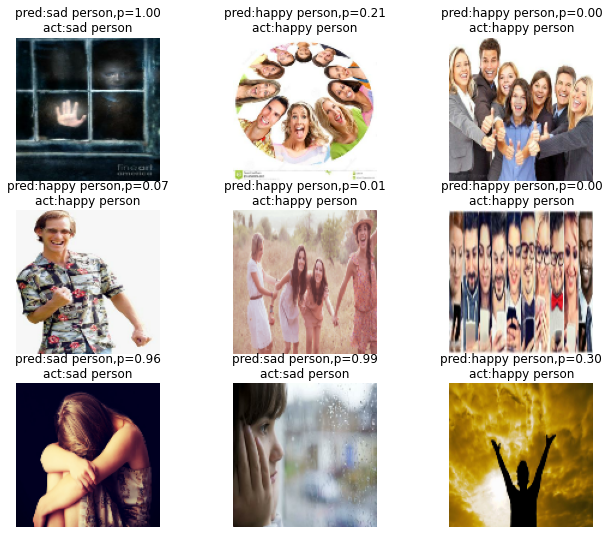

In [75]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions_prob = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions_prob < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(11, 9))
for i in range(9):
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i].astype("uint8"))
  plt.title(f'pred:{class_names[predictions[i]]},p={predictions_prob[i]:0.2f}\nact:{class_names[label_batch[i]]}')
  plt.axis("off")